<a href="https://colab.research.google.com/github/King-of-Haskul/Machine-Learning-And-Data-Science/blob/main/Cats_vs_dogs_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
base_dir = '/Users/pc/Downloads/cats_and_dog_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

### Feature Extraction using VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',  #specifies the weight checkpoint from whcih to initialize the model
                 include_top=False,  #not including the densely connected classifier on top
                 input_shape=(150,150,3))

conv_base.summary()

58892288/58889256 [==============================] - 183s 3us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
____________________________________________________________

#### Fast Feature Extraction without Data Augmentation

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) #Shape as defined by the final feautre map of VGG16 Convolutional base
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size =(150,150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i += 1
        if i*batch_size >= sample_count:
            break  #break loop after every image has been seen once.
    return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

Defining and training the densely connected classifier on the extracted features

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5)) #Adding dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 2s 22ms/step - loss: 0.6064 - accuracy: 0.6605 - val_loss: 0.4463 - val_accuracy: 0.8280
Epoch 2/30
100/100 [==============================] - 2s 21ms/step - loss: 0.4399 - accuracy: 0.7890 - val_loss: 0.3662 - val_accuracy: 0.8620
Epoch 3/30
100/100 [==============================] - 2s 21ms/step - loss: 0.3594 - accuracy: 0.8510 - val_loss: 0.3271 - val_accuracy: 0.8770
Epoch 4/30
100/100 [==============================] - 2s 21ms/step - loss: 0.3205 - accuracy: 0.8640 - val_loss: 0.3047 - val_accuracy: 0.8800
Epoch 5/30
100/100 [==============================] - 2s 21ms/step - loss: 0.2836 - accuracy: 0.8890 - val_loss: 0.2873 - val_accuracy: 0.8880
Epoch 6/30
100/100 [==============================] - 2s 21ms/step - loss: 0.2661 - accuracy: 0.8910 - val_loss: 0.2750 - val_accuracy: 0.8890
Epoch 7/30
100/100 [==============================] - 2s 22ms/step - loss: 0.2554 - accuracy: 0.8950 - val_loss: 0.2773 - val_accuracy: 0.8840

In [ ]:
import matplotlib.pyplot as plt

def plot_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    
    plt.show()

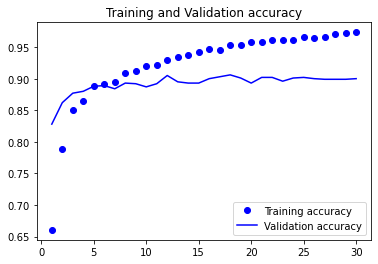

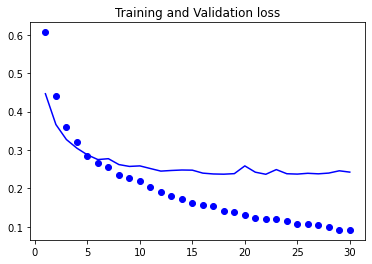

In [ ]:
plot_curves(history)

### Feature Extraction with Data Augmentation

NOTE: We haven't trained the model since it would be intractable on CPU :(

In [ ]:
model = models.Sequential()
model.add(conv_base) #Models behave just like layers and can be added as a layer in a Sequential model
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('This is the number of trainable weights before freezing the conv base: ', len(model.trainable_weights))
conv_base.trainable = False  #Freezing the convolutional base
print('This is the number of trainable weights after freezing the conv base: ', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base:  30
This is the number of trainable weights after freezing the conv base:  4


In [ ]:
#Data Augmentation generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
#Insert training step here